In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [22]:
import keras
from keras.applications import VGG16
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras import optimizers

from keras.models import load_model
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
import tensorflow as tf

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [6]:
tf.test.gpu_device_name()

!nvidia-smi

Wed Mar 24 06:58:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'

-rw------- 1 root root 90618980 Mar  4 04:51 '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'


In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/dogs_and_cats_small.zip

In [11]:
train_dir = 'train'
valid_dir = 'validation'
test_dir = 'test'

## 1. Data Preprocessing

### 1) ImageDataGenerator() & flow_from_directory()
- Normalization
  - ImageDataGenerator()
- Resizing & Generator
  - flow_from_directory()

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [27]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

Found 1000 images belonging to 2 classes.


## 2. Import VGG-16 Model & Some Layers Freezing

### 1) conv_base

In [13]:
conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


### 2) Model Information

In [14]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### 3) 'block5_conv1' Freezing
- Before 'weight' freezing

In [15]:
print('conv_base 동결 전 훈련 가능 가중치의 종류: ' , len(conv_base.trainable_weights))

# 종류 26?
# layer 13개, 각각 w, b가 있어서 파라미터 종류 26개
# trainable 속성 (unfrozon)
# non-trainable : frozen

conv_base 동결 전 훈련 가능 가중치의 종류:  26


- 'weight' Freezing

In [16]:
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1' :
    set_trainable = True

  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

- After 'weight' Freezing

In [17]:
print('conv_base 동결 후 훈련 가능 가중치의 종류: ' , len(conv_base.trainable_weights))
# 종류가 6개가 됨
# 위쪽의 파라미터 개수가 적으므로 trainable/non-trainable 이 반반 정도로 보임
# "fine tuning" (미세조정) 이라고 하지만 생각보다 trainable parameter가 많다

conv_base 동결 후 훈련 가능 가중치의 종류:  6


In [18]:
conv_base.summary()
# layer VGG16 은 param 14백만개
# 그 중 non-trainable이 7백7십

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## 3. Keras CNN Modeling with VGG-16 Freezed Layers

### 1) Model Define
- 'conv_base' & 'Classification' Network
- Dropout Layer

In [19]:
model = models.Sequential()

model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [23]:
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])
# 주의: 학습률을 굉장히 적게 주어야 한다
# 왜? 이미 weight값이 학습되어 있으므로! 이미 최소값 언저리에 있다
# 만약 학습률을 크게 주면 오히려 발산해버림
# 재학습을 시킬 때는 learning rate을 작게 주어야 한다
# optimizer를 import 해서 값을 (아주 작은 값으로) 지정해준다

### 3) Model Fit

In [24]:
%%time

Hist_dandc = model.fit(train_generator,
                       steps_per_epoch = 100,
                       epochs = 100,
                       validation_data = valid_generator,
                       validation_steps = 50)

Epoch 1/100
100/100 [==============================] - 47s 119ms/step - loss: 0.6798 - accuracy: 0.5855 - val_loss: 0.4724 - val_accuracy: 0.8320
Epoch 2/100
100/100 [==============================] - 11s 114ms/step - loss: 0.4461 - accuracy: 0.7861 - val_loss: 0.3531 - val_accuracy: 0.8500
Epoch 3/100
100/100 [==============================] - 12s 116ms/step - loss: 0.3167 - accuracy: 0.8740 - val_loss: 0.2772 - val_accuracy: 0.8950
Epoch 4/100
100/100 [==============================] - 11s 115ms/step - loss: 0.2481 - accuracy: 0.8985 - val_loss: 0.2429 - val_accuracy: 0.9050
Epoch 5/100
100/100 [==============================] - 12s 115ms/step - loss: 0.1876 - accuracy: 0.9294 - val_loss: 0.2239 - val_accuracy: 0.9110
Epoch 6/100
100/100 [==============================] - 11s 115ms/step - loss: 0.1673 - accuracy: 0.9370 - val_loss: 0.2280 - val_accuracy: 0.9040
Epoch 7/100
100/100 [==============================] - 11s 115ms/step - loss: 0.1492 - accuracy: 0.9463 - val_loss: 0.2051 -

### 4) Visualization
- Loss & Accuracy Visualization

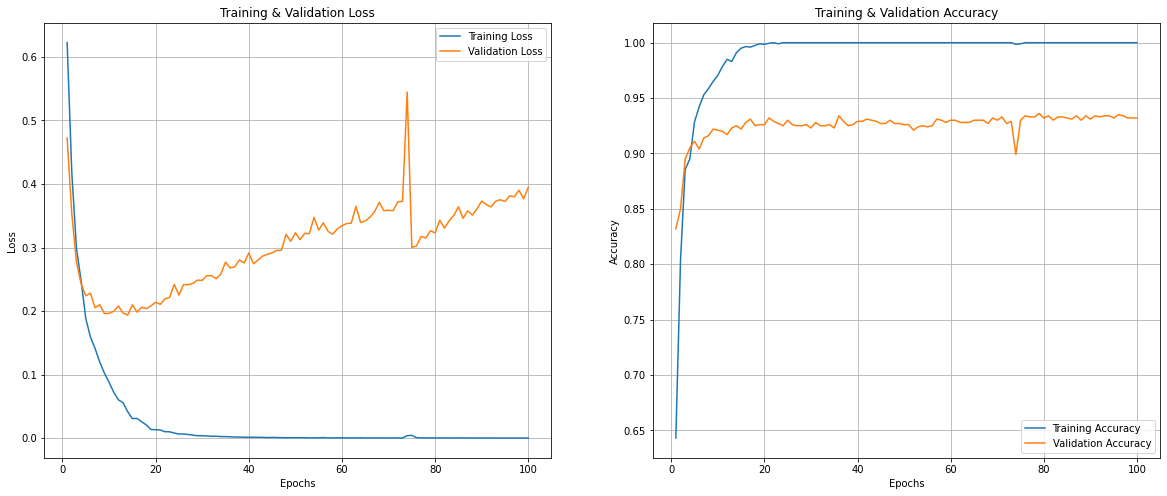

In [26]:
epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (20, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss' , 'Validation Loss'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy' , 'Validation Accuracy'])
plt.grid()

plt.show()

- Loss & Accuracy

In [28]:
loss, accuracy = model.evaluate(test_generator, steps = 50)

print('Loss = {:.5f}' .format(loss))
print('Accuracy = {:.5f}' .format(accuracy))

50/50 [==============================] - 4s 72ms/step - loss: 0.3897 - accuracy: 0.9300
Loss = 0.38975
Accuracy = 0.93000


## 4. Model Save & Load to Google Drive

In [29]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1) Model Save

In [30]:
model.save('/content/drive/My Drive/Colab Notebooks/models/008_dogs_and_cats_fine_tuning.h5')

In [31]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 479236
-rw------- 1 root root     34592 Mar 18 02:42 001_Model_iris.h5
-rw------- 1 root root  41498896 Mar 23 02:18 002_dogs_and_cats_small.h5
-rw------- 1 root root  41501624 Mar 23 07:12 003_dogs_and_cats_augmentation.h5
-rw------- 1 root root  39879700 Mar 23 06:41 004_logo_classification_with_augmentation.h5
-rw------- 1 root root  25199032 Mar 24 05:22 006_dogs_and_cats_feature_extraction.h5
-rw------- 1 root root 201873880 Mar 24 07:31 007_dogs_and_cats_VGG16.h5
-rw------- 1 root root 140748400 Mar 24 07:36 008_dogs_and_cats_fine_tuning.h5


### 2) Model Load

In [32]:
model_google = load_model('/content/drive/My Drive/Colab Notebooks/models/008_dogs_and_cats_fine_tuning.h5')

In [33]:
loss, accuracy = model_google.evaluate(test_generator, steps = 50)

print('Loss = {:.5f}' .format(loss))
print('Accuracy = {:.5f}' .format(accuracy))

50/50 [==============================] - 4s 73ms/step - loss: 0.3897 - accuracy: 0.9300
Loss = 0.38975
Accuracy = 0.93000
